In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression


## Exploratory Data Analysis

In [42]:
data = pd.read_csv('GercekZamanliTuketim-01012016-01112019.csv', encoding = 'unicode_escape')

In [43]:
data.shape

(33600, 3)

In [44]:
data.tail(10)

,Tarih,Saat,Tüketim Miktarý (MWh)
33590,01.11.2019,14:00,"35.732,88"
33591,01.11.2019,15:00,"35.859,75"
33592,01.11.2019,16:00,"36.268,51"
33593,01.11.2019,17:00,"37.011,89"
33594,01.11.2019,18:00,"37.199,91"
33595,01.11.2019,19:00,"36.056,96"
33596,01.11.2019,20:00,"35.130,19"
33597,01.11.2019,21:00,"33.947,64"
33598,01.11.2019,22:00,"32.877,69"
33599,01.11.2019,23:00,"31.590,75"


In [45]:
data.columns = ['Date', 'Hour', 'Consumption']

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33600 entries, 0 to 33599
Data columns (total 3 columns):
Date           33600 non-null object
Hour           33600 non-null object
Consumption    33600 non-null object
dtypes: object(3)
memory usage: 787.6+ KB


Arrange datatypes

In [47]:
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y').dt.strftime('%Y-%m-%d')
data['Consumption'] = data['Consumption'].str.replace('.','')
data['Consumption'] = data['Consumption'].str.replace(',','.')
data['Consumption'] = data['Consumption'].astype(str).astype(float)

In [48]:
data.head()

,Date,Hour,Consumption
0,2016-01-01,00:00,26277.24
1,2016-01-01,01:00,24991.82
2,2016-01-01,02:00,23532.61
3,2016-01-01,03:00,22464.78
4,2016-01-01,04:00,22002.91


check: Is there any missing date?

In [49]:
data=data.set_index('Date')
pd.date_range(start = '2016-01-01', end = '2019-11-01').difference(data.index)
data.reset_index(level=0, inplace=True)

2016-03-27 is missing. Now checking each day have 24 Hours?

In [50]:
data=data.set_index('Date')
a = data.groupby(['Date']).agg('count')
data.reset_index(level=0, inplace=True)
a['Hour'].unique()

array([24], dtype=int64)

In [51]:
tobeconcanated = data[(data['Date']<='2016-03-26') & (data['Date']>='2016-03-20')]
tobeconcanated = tobeconcanated.groupby('Hour', as_index=False)['Consumption'].mean()
ToBeInserted = data[data['Date'] == '2016-03-20'].replace('2016-03-20', '2016-03-27')
ToBeInserted = pd.merge(ToBeInserted[['Date','Hour']], tobeconcanated , how='left', on='Hour' )
data = pd.concat ([data, ToBeInserted])


In [52]:
data = data.sort_values(by=['Date', 'Hour'])

In [53]:
data.index.min()

0

In [54]:
duplicate_rows_df = data[data.duplicated()]
print("number duplicate rows:", duplicate_rows_df.shape)

number duplicate rows: (0, 3)


In [55]:
print(data.isnull().sum())

Date           0
Hour           0
Consumption    0
dtype: int64


In [56]:
data['Consumption_Lag_48']=data['Consumption'].shift(48)
data['Consumption_Lag_168']=data['Consumption'].shift(168)

In [57]:
data_train = data[data['Date']<'2019-11-01'].dropna()
data_test = data[data['Date']>='2019-11-01'].dropna()

In [58]:
data_test

,Date,Hour,Consumption,Consumption_Lag_48,Consumption_Lag_168
33576,2019-11-01,00:00,29417.56,27154.21,29563.43
33577,2019-11-01,01:00,28133.75,26157.42,28242.90
33578,2019-11-01,02:00,27358.60,25373.88,27258.74
33579,2019-11-01,03:00,26780.09,24911.43,26739.84
33580,2019-11-01,04:00,26511.54,24836.11,26555.35
33581,2019-11-01,05:00,27002.74,25233.76,26857.36
33582,2019-11-01,06:00,27945.43,26296.00,27783.77
33583,2019-11-01,07:00,29120.27,27575.60,28969.45
33584,2019-11-01,08:00,32815.46,31667.27,32153.21
33585,2019-11-01,09:00,34569.09,33138.17,33615.22


In [128]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    _abs = np.abs((y_true - y_pred) / y_true)
    return np.mean(_abs) * 100, _abs

In [130]:
naive_forecast_48, _abs48 = mean_absolute_percentage_error(data_test['Consumption'],data_test['Consumption_Lag_48'])
naive_forecast_168, _abs168 = mean_absolute_percentage_error(data_test['Consumption'],data_test['Consumption_Lag_168'])
print("Mape for Lag_48:", naive_forecast_48)
print("Mape for Lag_168:", naive_forecast_168)

naive_forecast_48 = [naive_forecast_48]
naive_forecast_168 = [naive_forecast_168]

Mape for Lag_48: 4.447784190089714
Mape for Lag_168: 2.63293095245023


## b)

Create x and y array for train data

In [144]:
Feature_List  = data_train.columns.to_list()
feature = [s for s in Feature_List if "Consumption_Lag" in s]
# Separating out the features
x_train = data_train.loc[:, feature].values
# Separating out the target
y_train = data_train.loc[:,['Consumption']].values 
model = LinearRegression().fit(x_train, y_train)
Feature_List  = data_test.columns.to_list()
feature = [s for s in Feature_List if "Consumption_Lag" in s]
# Separating out the features
x_test = data_test.loc[:, feature].values
# Separating out the target
y_test = data_test.loc[:,['Consumption']].values 
y_pred = model.predict(x_test)
print('predicted consumption for each hour in day of  2019-11-01: ', y_pred, sep='\n')
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
linear_mape, _abslinear_mape = mean_absolute_percentage_error(df['Actual'], df['Predicted'])
print( 'Mape for linear regression: '+ str(linear_mape))

   

predicted consumption for each hour in day of  2019-11-01: 
[[28931.61454172]
 [27781.88136361]
 [26911.78646317]
 [26436.9808162 ]
 [26297.15321807]
 [26615.30020106]
 [27539.95942282]
 [28697.39852084]
 [32018.63867675]
 [33411.044316  ]
 [33206.63225319]
 [33360.67796768]
 [31149.22474601]
 [31322.47572862]
 [33010.55175587]
 [33430.62541801]
 [34321.17044437]
 [35843.14662819]
 [36326.17850135]
 [35715.89054844]
 [34814.83083408]
 [33769.54553915]
 [32752.38245218]
 [31193.32927402]]
Mape for linear regression: 2.9152492352916752


In [145]:
linear_mape, linear_forecast = mean_absolute_percentage_error(df['Actual'], df['Predicted'])

In [146]:
linear_forecast = linear_forecast.tolist()

In [140]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: [1617.88420781]
slope: [[0.3253104  0.62510282]]


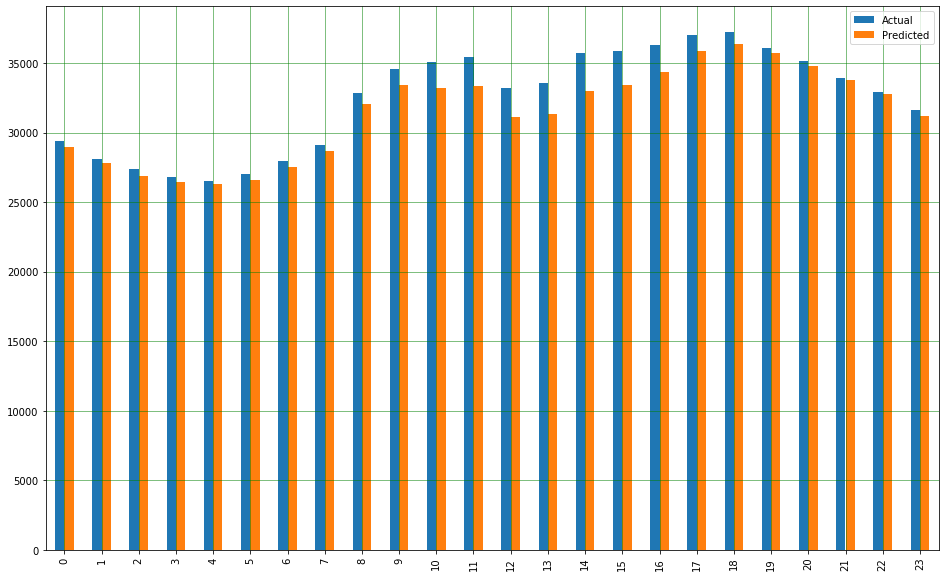

In [147]:
df.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

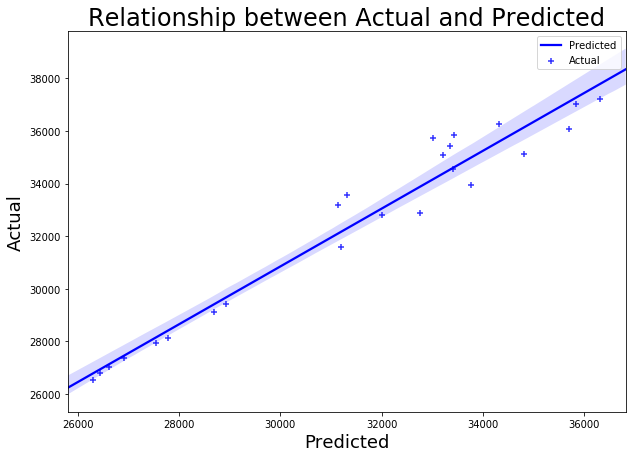

In [148]:
# Regression plot using seaborn.
fig = plt.figure(figsize=(10,7))
sns.regplot(x=df.Predicted,y=df.Actual,color='blue', marker='+')


# Legend, title and labels.
plt.legend(labels=['Predicted','Actual'])
plt.title('Relationship between Actual and Predicted', size=24)
plt.xlabel('Predicted', size=18)
plt.ylabel('Actual', size=18);

## c

In [160]:
def linear_regression (data_train, data_test):
    Feature_List  = data_train.columns.to_list()
    feature = [s for s in Feature_List if "Consumption_Lag" in s]
    # Separating out the features
    x_train = data_train.loc[:, feature].values
    # Separating out the target
    y_train = data_train.loc[:,['Consumption']].values 
    model = LinearRegression().fit(x_train, y_train)
    Feature_List  = data_test.columns.to_list()
    feature = [s for s in Feature_List if "Consumption_Lag" in s]
    # Separating out the features
    x_test = data_test.loc[:, feature].values
    # Separating out the target
    y_test = data_test.loc[:,['Consumption']].values 
    y_pred = model.predict(x_test)
    #print('predicted response:', y_pred, sep='\n')
    df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

    mean_mape, mape_abs =  mean_absolute_percentage_error(df['Actual'], df['Predicted'])
    
    return mean_mape

    
    



In [161]:
hours = data.Hour.unique()
hours = hours.tolist()
seperate_forecast=[]
for i in hours:
    mean_mape = linear_regression(data_train[data_train['Hour']==i], data_test[data_test['Hour']==i])
    print('Mape for ' + i + ': ' + str(mean_mape))
    seperate_forecast.append(mean_mape)

Mape for 00:00: 3.246554410858683
Mape for 01:00: 3.0430487540655493
Mape for 02:00: 3.5469125777935697
Mape for 03:00: 3.296289042445158
Mape for 04:00: 2.726957518553688
Mape for 05:00: 3.138384775908818
Mape for 06:00: 2.7917508482769913
Mape for 07:00: 1.942607854258057
Mape for 08:00: 2.2685744283453197
Mape for 09:00: 2.70208871848006
Mape for 10:00: 4.448514299599364
Mape for 11:00: 4.7523449468738255
Mape for 12:00: 5.157153609239525
Mape for 13:00: 5.506516771929009
Mape for 14:00: 6.692359746081615
Mape for 15:00: 5.994358449854611
Mape for 16:00: 4.796138783065254
Mape for 17:00: 2.844237629894735
Mape for 18:00: 2.033399183907496
Mape for 19:00: 0.43919228508239905
Mape for 20:00: 0.3018898173535693
Mape for 21:00: 0.13011769449538932
Mape for 22:00: 0.17300509102895162
Mape for 23:00: 0.7603395053128135


## d

## Wide format 


In [163]:
data_train.head()

,Date,Hour,Consumption,Consumption_Lag_48,Consumption_Lag_168
168,2016-01-08,00:00,28602.02,29189.27,26277.24
169,2016-01-08,01:00,27112.37,27614.02,24991.82
170,2016-01-08,02:00,25975.34,26578.97,23532.61
171,2016-01-08,03:00,25315.55,25719.19,22464.78
172,2016-01-08,04:00,25128.15,25864.63,22002.91


In [164]:
data_wide = data.pivot(index='Date', columns='Hour', values=['Consumption_Lag_48', 'Consumption_Lag_168', 'Consumption'])
data_wide.columns = ['Lag_day_' + str(i) + '_' + str(j) for i in (2, 7) for j in range(24)] + ['Consumption_{}'.format(i) for i in range(24)]
data_wide = data_wide.dropna().reset_index()


In [165]:
data_wide.head(5)

,Date,Lag_day_2_0,Lag_day_2_1,Lag_day_2_2,Lag_day_2_3,Lag_day_2_4,Lag_day_2_5,Lag_day_2_6,Lag_day_2_7,Lag_day_2_8,...,Consumption_14,Consumption_15,Consumption_16,Consumption_17,Consumption_18,Consumption_19,Consumption_20,Consumption_21,Consumption_22,Consumption_23
0,2016-01-08,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
1,2016-01-09,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
2,2016-01-10,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66
3,2016-01-11,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,36383.06,36013.19,36848.54,37368.40,35697.30,34482.37,33526.95,32634.16,32791.35,31147.83
4,2016-01-12,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,34934.00,34785.11,35690.28,36566.50,35055.97,33912.94,33131.98,32332.76,32523.14,30906.87


In [166]:
data_train_lasso = data_wide[data_wide['Date']<'2019-11-01'].dropna()
data_test_lasso = data_wide[data_wide['Date']>='2019-11-01'].dropna()

In [167]:
data_test_lasso

,Date,Lag_day_2_0,Lag_day_2_1,Lag_day_2_2,Lag_day_2_3,Lag_day_2_4,Lag_day_2_5,Lag_day_2_6,Lag_day_2_7,Lag_day_2_8,...,Consumption_14,Consumption_15,Consumption_16,Consumption_17,Consumption_18,Consumption_19,Consumption_20,Consumption_21,Consumption_22,Consumption_23
1393,2019-11-01,27154.21,26157.42,25373.88,24911.43,24836.11,25233.76,26296.0,27575.6,31667.27,...,35732.88,35859.75,36268.51,37011.89,37199.91,36056.96,35130.19,33947.64,32877.69,31590.75


In [168]:
def lasso_regression (data_train, data_test, hour):
    Feature_List  = data_train.columns.to_list()
    feature = [s for s in Feature_List if "Lag" in s]
    # Separating out the features
    x_train = data_train.loc[:, feature].values
    # Separating out the target
    y_train = data_train.loc[:,['Consumption_'+ str(hour)]].values
    y_train = np.ravel(y_train)
    alpha = np.logspace(-10, 1, 400)
    lasso = LassoCV(cv=10, normalize=True, tol=0.001, selection='random', random_state=42, alphas=alpha,max_iter=5000)
    lasso.fit(x_train, y_train)
    # Separating out the features
    x_test = data_test.loc[:, feature].values
    # Separating out the target
    y_test = data_test.loc[:,['Consumption_'+ str(hour)]].values 
    y_pred = lasso.predict(x_test)
    #print('predicted response:', y_pred, sep='\n')
    df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    mean_mape, mape_abs =  mean_absolute_percentage_error(df['Actual'], df['Predicted'])
    
    return mean_mape


In [169]:
data_train_lasso.head()

,Date,Lag_day_2_0,Lag_day_2_1,Lag_day_2_2,Lag_day_2_3,Lag_day_2_4,Lag_day_2_5,Lag_day_2_6,Lag_day_2_7,Lag_day_2_8,...,Consumption_14,Consumption_15,Consumption_16,Consumption_17,Consumption_18,Consumption_19,Consumption_20,Consumption_21,Consumption_22,Consumption_23
0,2016-01-08,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
1,2016-01-09,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
2,2016-01-10,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66
3,2016-01-11,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,36383.06,36013.19,36848.54,37368.40,35697.30,34482.37,33526.95,32634.16,32791.35,31147.83
4,2016-01-12,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,34934.00,34785.11,35690.28,36566.50,35055.97,33912.94,33131.98,32332.76,32523.14,30906.87


In [171]:
lasso_forecast = []
hours = range(24)
for hour in hours:
    output = lasso_regression(data_train_lasso, data_test_lasso, hour)
    print('Mape for'+' '+ 'Hour'+' '+str(hour)+':' + str(output))
    lasso_forecast.append(output)

Mape for Hour 0:1.9322799941792257
Mape for Hour 1:1.67384284921966
Mape for Hour 2:1.6829542918841558
Mape for Hour 3:1.69417878980558
Mape for Hour 4:2.1731700687744744
Mape for Hour 5:1.5735803104910522
Mape for Hour 6:1.7592178993030636
Mape for Hour 7:2.1423113465143944
Mape for Hour 8:1.5707028712791973
Mape for Hour 9:0.565477578080559
Mape for Hour 10:1.427036132204395
Mape for Hour 11:2.128292182400681
Mape for Hour 12:2.071779802921641
Mape for Hour 13:3.439188703523177
Mape for Hour 14:3.7476429136610174
Mape for Hour 15:3.073115283315319
Mape for Hour 16:1.0284693859774359
Mape for Hour 17:1.0399375390270837
Mape for Hour 18:1.580879891880459
Mape for Hour 19:2.2189084617553103
Mape for Hour 20:1.398420491708004
Mape for Hour 21:2.1401654275204143
Mape for Hour 22:2.268244347794655
Mape for Hour 23:1.610737088776072


## f

In [173]:
naive_forecast_168

[2.63293095245023]

In [184]:
dataframe = pd.DataFrame(
    {'naive_168': _abs168,
     'naive_48': _abs48,
     'linear_forecast': linear_forecast
     #'seperate_hour_forecast': seperate_forecast,
     #'lasso_forecast': lasso_forecast
    })


In [186]:
dataframe_boxplot = pd.DataFrame(
    {
     'seperate_hour_forecast': seperate_forecast,
     'lasso_forecast': lasso_forecast
    })


In [175]:
dataframe

,naive_168,naive_48,linear_forecast,seperate_hour_forecast,lasso_forecast
0,0.004959,0.076939,0.016519,3.246554,1.932280
1,0.003880,0.070248,0.012507,3.043049,1.673843
2,0.003650,0.072545,0.016332,3.546913,1.682954
3,0.001503,0.069778,0.012812,3.296289,1.694179
4,0.001652,0.063196,0.008087,2.726958,2.173170
5,0.005384,0.065511,0.014348,3.138385,1.573580
6,0.005785,0.059023,0.014509,2.791751,1.759218
7,0.005179,0.053044,0.014522,1.942608,2.142311
8,0.020181,0.034989,0.024282,2.268574,1.570703
9,0.027593,0.041393,0.033499,2.702089,0.565478


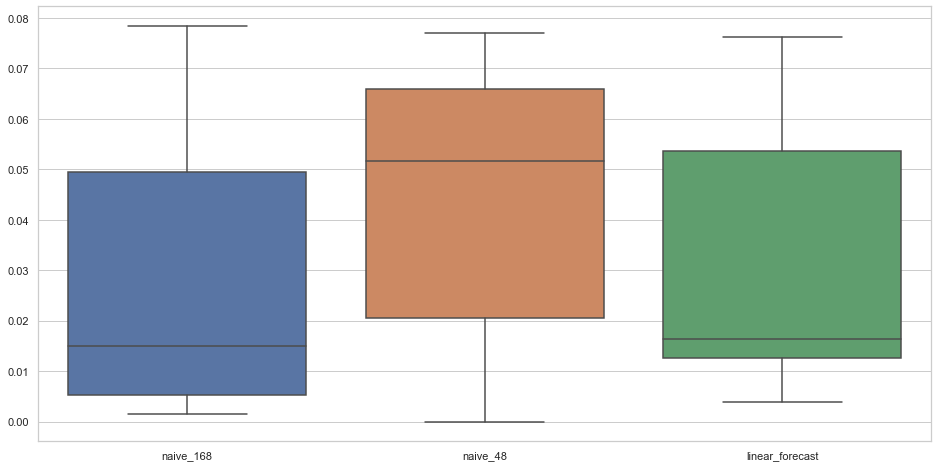

In [188]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(data=dataframe, showfliers=False)

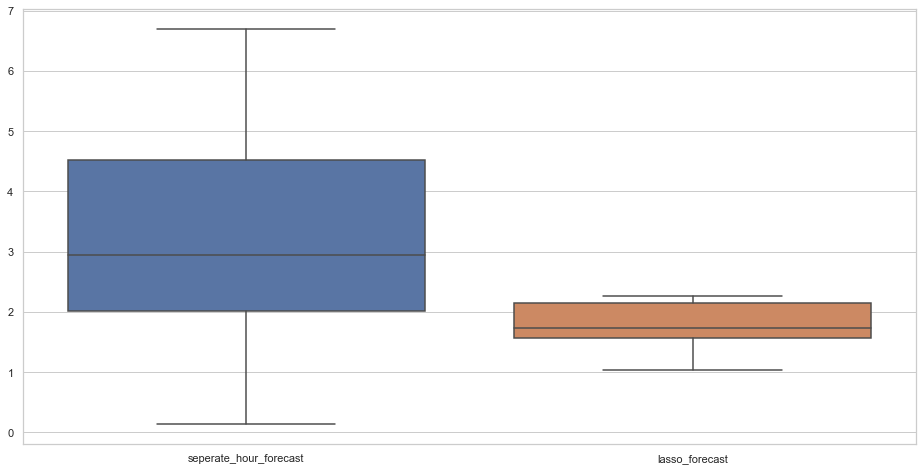

In [189]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(data=dataframe_boxplot, showfliers=False)

I think, best approch is the naive forecast because of the low mape values compare to the other approaches. The reason  why there are two seperate box plot graphs is the scale problem of approches.